# Predicting Location via Indoor Positioning System 
## Analysis and Modeling in Python 
This script and subsequent notebooks are the Python conversion of the Indoor Location case study from the book, 'Data Science in R' by Nolan and Lang. http://rdatasciencecases.org/code.html <BR>
* Team: Jonathan Tan, Lance Dacy, Reannan Mcdaniel, Shawn Jung 
* Last Update: 5/14/2020 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.spatial import distance
from sklearn.model_selection import KFold
%matplotlib inline 

In [2]:
# Let's load dataframes
offline_pivot = pd.read_csv('./data/offline_pivot.csv')
online_pivot = pd.read_csv('./data/online_pivot.csv')

# re-add pos_x and pos_y for distance error calculation in later stage
offline_pivot[['pos_x', 'pos_y']] = offline_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)
online_pivot[['pos_x', 'pos_y']] = online_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)

In [3]:
test0 = online_pivot.iloc[0,1:8]
train0 = offline_pivot.iloc[0,1:8]

In [4]:
# the Euclidean distance of first records of each data frame can be calcualted like this. 
np.sqrt(np.sum(np.square((np.array(test0) - np.array(train0)))))
# But we will use the scipy library to compare Euclidean and Manhattan distance methods. 

10.412954827804205

In [5]:
distance.euclidean(test0, train0) 
distance.cityblock(test0, train0)

19.368059828511

In [6]:
# The function returns top k nearest neighbors  
def find_NN(test_array, train_df, k=1, distance_type=distance.cityblock):
    dist = []
    for i in range(train_df.shape[0]):
        #d = np.sqrt(np.sum(np.square((np.array(test_array) - np.array(train_df)[i]))))
        d = distance_type(test_array, np.array(train_df)[i])
        dist.append(d)
    
    dist_result = np.array(dist)
    
    # return the indices of top n lowest values

    return dist_result.argsort()[0:k][::-1]


In [7]:
# The function calculates weighted or simple averaged predicted location, and compare to the actual location. And then return the gap as error 
def error_calc(original_index, predict_index, weighted_mean=True, distance_type=distance.cityblock):
    original_xy = online_pivot.iloc[original_index][['pos_x', 'pos_y']]
    dist = []
    pred_xy = np.zeros([len(predict_index),2])
    for i,p in enumerate(predict_index):
        xy = offline_pivot.iloc[p][['pos_x', 'pos_y']]
        dist.append(distance_type(original_xy, xy))
        pred_xy[i] = xy
    # in case we use weighted mean, 
    if weighted_mean:
        avg_pred_x = np.average(pred_xy[:,0], weights=dist)
        avg_pred_y = np.average(pred_xy[:,1], weights=dist)
    else:
        avg_pred_x = np.average(pred_xy[:,0])
        avg_pred_y = np.average(pred_xy[:,1])

    error = distance_type(original_xy, (avg_pred_x, avg_pred_y))
    
    return(error)


In [8]:
# This function calculated the mean errors per combination of datasets, k(number of neighbors), distance type and averaging type
def location_scoring(test_df, train_df, k=1, distance_type=distance.cityblock, weighted_mean=True):
    errors = []
    for i in range(test_df.shape[0]):
        predicted_nn = find_NN(test_df.iloc[i], train_df, k, distance_type)
        error = error_calc(i, predicted_nn, weighted_mean, distance_type)
        errors.append(error)
    
    return np.mean(errors)


In [9]:
score = location_scoring(online_pivot.iloc[:,1:8], offline_pivot.iloc[:,1:8], k=1, distance_type=distance.cityblock, weighted_mean=True)
print(score)

2.8374999999999995


### Case 1-2
Assuming we cannot use the ONLINE data, we found the best fit by using cross-validation method

In [10]:
# Let's define 6 MAC addresses, by choosing the one end with 'CD'. 
offline_cd = offline_pivot.iloc[:,1:8].drop(['00:0f:a3:39:e1:c0'], axis=1)
online_cd = online_pivot.iloc[:,1:8].drop(['00:0f:a3:39:e1:c0'], axis=1)

# These are data sets when choosing 'C0'
offline_c0 = offline_pivot.iloc[:,1:8].drop(['00:0f:a3:39:dd:cd'], axis=1)
online_c0 = online_pivot.iloc[:,1:8].drop(['00:0f:a3:39:dd:cd'], axis=1)

# Datasets when we take all 7 MAC addresses
offline_all = offline_pivot.iloc[:,1:8]
online_all = online_pivot.iloc[:,1:8]


In [11]:
# define kfold splits over offline data. We adopt 10 CV splits 
#from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42)
kf.get_n_splits(offline_cd)

10

In [12]:
k_space = [1,2,3,4,5,6,7,8,9,10]
mean_errors = []
weighted_means = [True, False]

for mean_method in weighted_means:
    for k in k_space:
        scores = []
        for train_index, test_index in kf.split(offline_cd):
            scores.append(location_scoring(offline_cd.iloc[test_index], offline_cd.iloc[train_index], k=k, weighted_mean=mean_method))

        mean_error = np.mean(scores)
        mean_errors.append(mean_error)
        print(f'weighted_mean={mean_method}, k = {k} , mean error = {mean_error:.4f}')



weighted_mean=True, k = 1 , mean error = 17.1268
weighted_mean=True, k = 2 , mean error = 17.8918
weighted_mean=True, k = 3 , mean error = 18.1771
weighted_mean=True, k = 4 , mean error = 18.3314
weighted_mean=True, k = 5 , mean error = 18.7355
weighted_mean=True, k = 6 , mean error = 18.5905
weighted_mean=True, k = 7 , mean error = 18.8196
weighted_mean=True, k = 8 , mean error = 18.9616
weighted_mean=True, k = 9 , mean error = 19.0123
weighted_mean=True, k = 10 , mean error = 19.0677
weighted_mean=False, k = 1 , mean error = 17.1268
weighted_mean=False, k = 2 , mean error = 16.8289
weighted_mean=False, k = 3 , mean error = 16.5140
weighted_mean=False, k = 4 , mean error = 16.4129
weighted_mean=False, k = 5 , mean error = 16.6082
weighted_mean=False, k = 6 , mean error = 16.4242
weighted_mean=False, k = 7 , mean error = 16.5583
weighted_mean=False, k = 8 , mean error = 16.5728
weighted_mean=False, k = 9 , mean error = 16.6158
weighted_mean=False, k = 10 , mean error = 16.6168


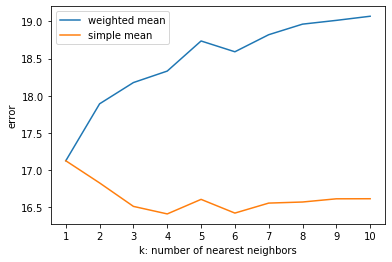

In [13]:
# It turns out, the mean distance between original location and predicted location is the lowset when k=4 with simple mean method

ax = plt.plot(k_space, mean_errors[0:10], label='weighted mean')
ax = plt.plot(k_space, mean_errors[10:20], label='simple mean')

plt.xticks(k_space)
plt.xlabel('k: number of nearest neighbors')
plt.ylabel('error')
plt.legend()
plt.show()

Case 1-3 and 1-4 <BR>
Let's compare which one gives better performance. From our analysis, the error was the lowest when we take 'cd' MAC address groups

In [14]:
scores_c0 = location_scoring(online_c0, offline_c0, k=4, weighted_mean=False)
scores_cd = location_scoring(online_cd, offline_cd, k=4, weighted_mean=False)
scores_all = location_scoring(online_all, offline_all, k=4, weighted_mean=False)

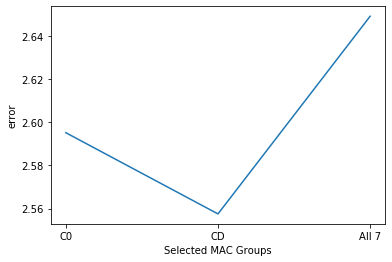

In [16]:
plt.plot(['C0', 'CD', 'All 7'], [scores_c0, scores_cd, scores_all])
plt.xlabel('Selected MAC Groups')
plt.ylabel('error')
plt.show()